# **Library**

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# **Read Data**

In [64]:
df = pd.read_csv('../data/processed_data.csv')
df.head()

,element_id,site_id,seller_id,Dominio_normalizado,Titulo,Marca,Precio,Rule,Score,Total,Moderado,Fake,Rollback,FK_TEST1,FK_TEST2
0,ARG1000130348,ARGENTINA,924394736,COMPUTER_PROCESSORS,Microprocesador Intel Core I3 12100 12mb Bx807...,Intel,222599.0,NOT_MODERATED,0.11,1,0,0,0,0,0
1,ARG1002056504,ARGENTINA,60385780,COMPUTER_MONITORS,Monitor Gamer Samsung Con Pantalla De 25 60hz...,Samsung,767000.0,NOT_MODERATED,0.29,1,0,0,0,0,0
2,ARG1002630435,ARGENTINA,1085316688,SUNGLASSES,Anteojos De Sol Polarizados Ray-ban Erika Clas...,Ray-Ban,246510.0,NOT_MODERATED,0.51,1,0,0,0,0,0
3,ARG1003499360,ARGENTINA,189266308,HARD_DRIVES_AND_SSDS,Ssd Externo Kingston Xs1000 1tb Negro Usb 3.2 ...,Kingston,179999.0,NOT_MODERATED,0.32,1,0,0,0,0,0
4,ARG1004623658,ARGENTINA,127503700,RAM_MEMORY_MODULES,Memoria Ram Valueram Color Verde 8gb 1 Kingsto...,Kingston,22399.0,NOT_MODERATED,0.80,1,0,0,0,0,0


In [65]:
df = df.drop(columns=['element_id', "seller_id", "Titulo", "Total", "Moderado", "Rollback", "FK_TEST1", "FK_TEST2", "Rule"])
df = df[df["Score"] > 0.76].copy().reset_index(drop=True)
df.head()

,site_id,Dominio_normalizado,Marca,Precio,Score,Fake
0,ARGENTINA,RAM_MEMORY_MODULES,Kingston,22399.0,0.80,0
1,ARGENTINA,SPEAKERS,Xiaomi,86249.5,0.91,1
2,ARGENTINA,NOTEBOOKS,Lenovo,935999.5,0.99,1
3,ARGENTINA,NOTEBOOKS,Lenovo,1539998.9,0.84,0
4,ARGENTINA,PERFUMES,Carolina Herrera,343840.0,0.80,0


# **Process Data**

In [66]:
categorical_columns = df.select_dtypes(exclude=[int, float]).columns
df_final = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=float)
df_final.head()

,Precio,Score,Fake,site_id_BRASIL,site_id_CHILE,site_id_COLOMBIA,site_id_MEXICO,site_id_PERU,Dominio_normalizado_BODY_SKIN_CARE_PRODUCTS,Dominio_normalizado_CELLPHONES,...,Marca_Simil Motorola,Marca_Simil Ray-Ban,Marca_Simil Samsung,Marca_Simil SanDisk,Marca_Simil Sony,Marca_Simil Versace,Marca_Simil Xiaomi,Marca_Sony,Marca_Versace,Marca_Xiaomi
0,22399.0,0.80,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,86249.5,0.91,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,935999.5,0.99,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1539998.9,0.84,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,343840.0,0.80,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
X = df_final.drop(columns=["Fake"])
y = df_final["Fake"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
columns = X_train.columns
scaler = StandardScaler()
scaler.fit(X_train)
X_train.values[:] = scaler.transform(X_train)
X_test.values[:] = scaler.transform(X_test)


# **Model**

In [68]:
xgboost_model = xgboost.XGBClassifier()
xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

Accuracy: 0.9001713796058269
Precision: 0.880093131548312
Recall: 0.8532731376975169


# **Feature Importance**

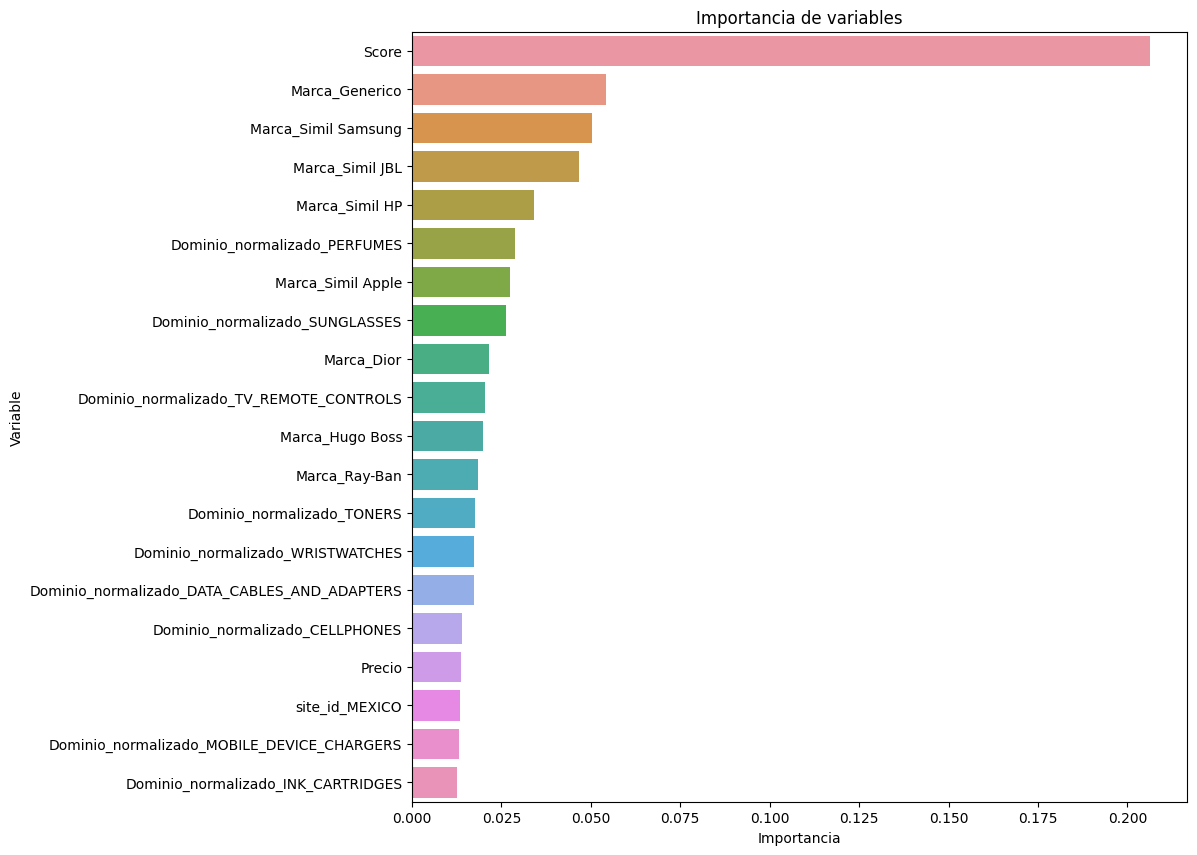

In [70]:
# Obtener "feature importances"
importancias = xgboost_model.feature_importances_

# Se crea DataFrame con los valores de las features importance
importancias_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': importancias
})

# Se organiza el DataFrame
importancias_df = importancias_df.sort_values(by='Importancia', ascending=False).head(20)

# Se grafica
plt.figure(figsize=(10, 10))
sns.barplot(data=importancias_df, x='Importancia', y='Variable', orient='h')
plt.title('Importancia de variables')
plt.show()

In [77]:
explainer = shap.TreeExplainer(xgboost_model)

[16:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


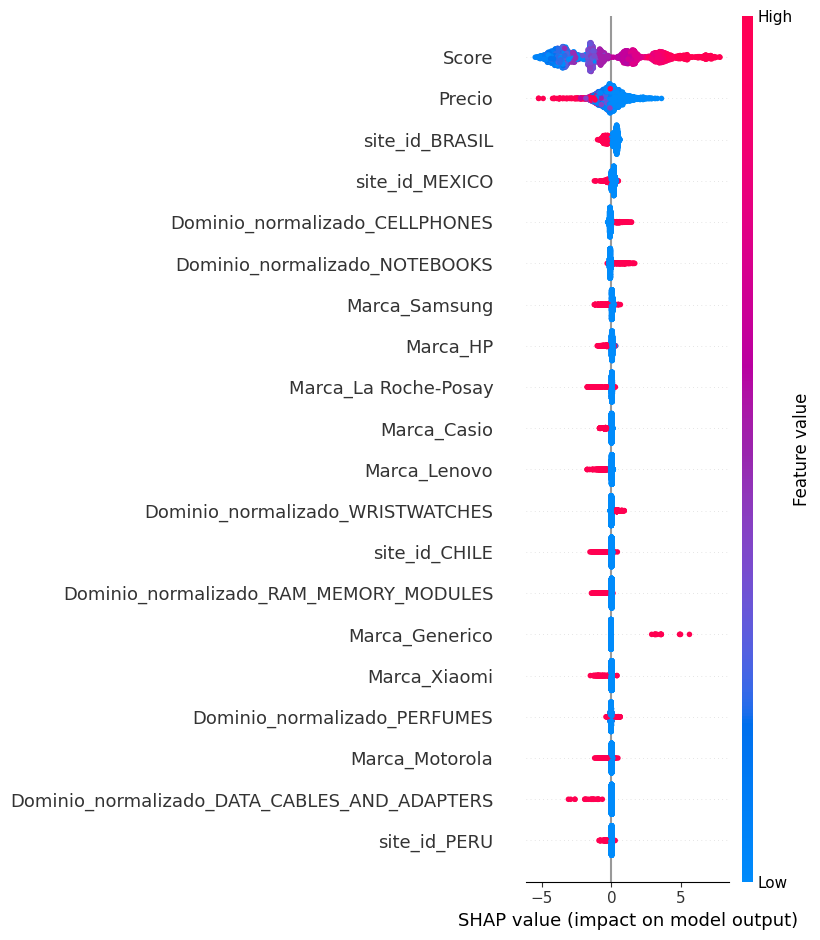

In [82]:
shap_values_test = explainer(X_test[X_test.columns])

shap.summary_plot(shap_values_test, X_test[X_test.columns], feature_names=X_test.columns)